# Li+ Analysis Using pdbionsurvey

`pdbionsurvey` is a library that seeks to quantify the interactions between cations and polarized atoms in proteins, namely oxygen. The library attempts to simplify the amount of ad hoc coding that must be done while still maintaining flexibility in its use. Here, we will demonstrate the use of `pdbionsurvey` in analyzing cation/oxygen interactions in proteins. We will use lithium ions (Li+) as our example ion since it is less common than Na+ or K+ which decreases the amount of data to process and therefore the computation time.

### First Things First: imports and Variables

##### Necessary import statements
We need to import a few packages to make things more readily useable.

In [3]:
# import the library that is being demonstrated
import pdbionsurvey.coordination
import pdbionsurvey.collection
import pdbionsurvey.analysis

# needed to make protein universes
import MDAnalysis as mda

# needed to make and use sims
import mdsynthesis as mds

# needed for path definitions
import os

# needed for displaying plots
import matplotlib.pyplot as plt
%matplotlib inline

# needed for simplicity
import warnings
warnings.filterwarnings('ignore')

##### Path definitions

We should put all of our files in directories and sort them nicely. In general, these directories can live anywhere, which allows people to use the package to suit their own needs.

In [2]:
# directory for the pdbs
path = mds.Tree('/nfs/homes/kreidy/Projects/PDB_Ion_Survey/pdbs/')

# directory for the sims
# it is important that this directory is empty,
# otherwise, mislabeling may happen later
simdir = path['sims_folder/']

# directory for DataFrames
datapath = path['dataframes']

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:25.693663. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
path.draw()

pdbs/
 +-- 4K1E.pdb
 +-- 4ELC.pdb
 +-- 5G02.pdb
 +-- 1H4E.pdb
 +-- 2V1M.pdb
 +-- 5CMK.pdb
 +-- 1NQJ.pdb
 +-- 5DJG.pdb
 +-- sims_folder/
 |   +-- 4FAT/
 |   |   +-- 4FAT.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 2284.csv
 |   |   +-- Sim.c30e9a6d-80b2-4246-9fa3-5dc9a51a6f7e.json
 |   +-- 3HHI/
 |   |   +-- Sim.8999ab71-6ea7-42d2-999c-4e538d0323b9.json
 |   |   +-- 3HHI.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 4120.csv
 |   +-- 3GTA/
 |   |   +-- Sim.243329b4-3620-4057-b961-4cbb212781ac.json
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 1507.csv
 |   |   +-- 3GTA.pdb
 |   +-- 5I5A/
 |   |   +-- 5I5A.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 613.csv
 |   |   +-- Sim.c9ce7187-9b16-461f-961c-a08763f9bce7.json
 |   +-- 3F7H/
 |   |   +-- Sim.3334c300-2a5d-49d6-a354-b4f1c3ea421b.json
 |   |   +-- 3F7H.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 1519

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:25.700887. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Obtaining Data from the PDB

### Get PDB ids
We need to query the PDB for all of the PDB ids cooresponding to files that contain Li+ ions.

`pdbionsurvey.collection.get_pdb_ids` has other parameters that are left with their defaults:  
`containsProtein=True` will filter out any molecules that do not contain proteins,  
`containsDNA=False` will filter out any molecules that contain DNA (because it's set to false),  
`containsRna=False` will filter out any molecules that contain RNA,  
and `containsHybrid=False` will filter out any molecules that contain multiple molecule types.

In [4]:
# find and store the PDB ids
ids = pdbionsurvey.collection.get_pdb_ids('Li')

# display the number of PDB ids
print len(ids)

63


/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:25.825181. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Download .pdb files corresponding to PDB ids

Good to break up scripts into modules and functions to demonstrate how components work to produce data. Separating querying from analysis allows for more understanding and flexibility in use.

In [5]:
# download each .pdb file individually
for pdbid in ids:
    pdbionsurvey.collection.get_pdb_file(pdbid, path.abspath)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:27.822978. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [6]:
path.draw()

pdbs/
 +-- 4K1E.pdb
 +-- 4ELC.pdb
 +-- 5G02.pdb
 +-- 1H4E.pdb
 +-- 2V1M.pdb
 +-- 5CMK.pdb
 +-- 1NQJ.pdb
 +-- 5DJG.pdb
 +-- sims_folder/
 |   +-- 4FAT/
 |   |   +-- 4FAT.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 2284.csv
 |   |   +-- Sim.c30e9a6d-80b2-4246-9fa3-5dc9a51a6f7e.json
 |   +-- 3HHI/
 |   |   +-- Sim.8999ab71-6ea7-42d2-999c-4e538d0323b9.json
 |   |   +-- 3HHI.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 4120.csv
 |   +-- 3GTA/
 |   |   +-- Sim.243329b4-3620-4057-b961-4cbb212781ac.json
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 1507.csv
 |   |   +-- 3GTA.pdb
 |   +-- 5I5A/
 |   |   +-- 5I5A.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 613.csv
 |   |   +-- Sim.c9ce7187-9b16-461f-961c-a08763f9bce7.json
 |   +-- 3F7H/
 |   |   +-- Sim.3334c300-2a5d-49d6-a354-b4f1c3ea421b.json
 |   |   +-- 3F7H.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 1519

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:27.831809. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Making Sims

We make sims using `mdsynthesis` to store our data so that we can easily access it in the future. We can use `pdbionsurvey.analysis.make_sims` to quickly make them consistently for the purpose of coorcination analysis.

In [7]:
pdbfiles = path.glob('*.pdb')
print len(pdbfiles)

63


/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:27.900485. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
# make sims
sims = pdbionsurvey.analysis.make_sims(simdir, pdbfiles)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:27.920770. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
path.draw()

pdbs/
 +-- 4K1E.pdb
 +-- 4ELC.pdb
 +-- 5G02.pdb
 +-- 1H4E.pdb
 +-- 2V1M.pdb
 +-- 5CMK.pdb
 +-- 1NQJ.pdb
 +-- 5DJG.pdb
 +-- sims_folder/
 |   +-- 4FAT/
 |   |   +-- 4FAT.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 2284.csv
 |   |   +-- Sim.c30e9a6d-80b2-4246-9fa3-5dc9a51a6f7e.json
 |   +-- 3HHI/
 |   |   +-- Sim.8999ab71-6ea7-42d2-999c-4e538d0323b9.json
 |   |   +-- 3HHI.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 4120.csv
 |   +-- 3GTA/
 |   |   +-- Sim.243329b4-3620-4057-b961-4cbb212781ac.json
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 1507.csv
 |   |   +-- 3GTA.pdb
 |   +-- 5I5A/
 |   |   +-- 5I5A.pdb
 |   |   +-- coordination/
 |   |   |   +-- LI/
 |   |   |       +-- 613.csv
 |   |   +-- Sim.c9ce7187-9b16-461f-961c-a08763f9bce7.json
 |   +-- 3F7H/
 |   |   +-- Sim.3334c300-2a5d-49d6-a354-b4f1c3ea421b.json
 |   |   +-- 3F7H.pdb
 |   |   +-- coordination/
 |   |       +-- LI/
 |   |           +-- 1519

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:29.219404. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Making and Storing Radial Distribution Functions

We use MDAnalysis to create a protein Universe and to select the ions that we care about. From there, we can use `pdbionsurvey.coordination.en` to create a radial distribution function for each .pdb file. We then store our data as .csv files for easy access and sorting.

In [10]:
pdbionsurvey.analysis.define_universe(sims, pdbfiles)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:29.287598. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
simdir.draw()

sims_folder/
 +-- 4FAT/
 |   +-- 4FAT.pdb
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 2284.csv
 |   +-- Sim.c30e9a6d-80b2-4246-9fa3-5dc9a51a6f7e.json
 +-- 3HHI/
 |   +-- Sim.8999ab71-6ea7-42d2-999c-4e538d0323b9.json
 |   +-- 3HHI.pdb
 |   +-- coordination/
 |       +-- LI/
 |           +-- 4120.csv
 +-- 3GTA/
 |   +-- Sim.243329b4-3620-4057-b961-4cbb212781ac.json
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 1507.csv
 |   +-- 3GTA.pdb
 +-- 5I5A/
 |   +-- 5I5A.pdb
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 613.csv
 |   +-- Sim.c9ce7187-9b16-461f-961c-a08763f9bce7.json
 +-- 3F7H/
 |   +-- Sim.3334c300-2a5d-49d6-a354-b4f1c3ea421b.json
 |   +-- 3F7H.pdb
 |   +-- coordination/
 |       +-- LI/
 |           +-- 1519.csv
 +-- 1DGD/
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 3248.csv
 |   +-- 1DGD.pdb
 |   +-- Sim.680a2261-cb82-4534-8a90-7374603252ab.json
 +-- 3D2O/
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 3831.csv
 |   +-- Si

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:37.639971. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
for i in sims:
    # make a protein Universe
    u = i.universe

    # select Li atoms
    ions = u.select_atoms('name LI')

    for ion in ions:
        # make radial distribution function
        df = pdbionsurvey.coordination.en(u, ion)
        
        # make directory if it doesn't exist
        i['coordination/LI/'].make()

        # store radial distribution function in .csv file
        df.to_csv(i['coordination/LI/{}.csv'.format(ion.number)].abspath)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: DeprecationWarning: `number` is deprecated!
This will be removed in version 0.16.0; use `index` property instead
/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:37.750011. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [13]:
simdir.draw()

sims_folder/
 +-- 4FAT/
 |   +-- 4FAT.pdb
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 2284.csv
 |   +-- Sim.c30e9a6d-80b2-4246-9fa3-5dc9a51a6f7e.json
 +-- 3HHI/
 |   +-- Sim.8999ab71-6ea7-42d2-999c-4e538d0323b9.json
 |   +-- 3HHI.pdb
 |   +-- coordination/
 |       +-- LI/
 |           +-- 4120.csv
 +-- 3GTA/
 |   +-- Sim.243329b4-3620-4057-b961-4cbb212781ac.json
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 1507.csv
 |   +-- 3GTA.pdb
 +-- 5I5A/
 |   +-- 5I5A.pdb
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 613.csv
 |   +-- Sim.c9ce7187-9b16-461f-961c-a08763f9bce7.json
 +-- 3F7H/
 |   +-- Sim.3334c300-2a5d-49d6-a354-b4f1c3ea421b.json
 |   +-- 3F7H.pdb
 |   +-- coordination/
 |       +-- LI/
 |           +-- 1519.csv
 +-- 1DGD/
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 3248.csv
 |   +-- 1DGD.pdb
 |   +-- Sim.680a2261-cb82-4534-8a90-7374603252ab.json
 +-- 3D2O/
 |   +-- coordination/
 |   |   +-- LI/
 |   |       +-- 3831.csv
 |   +-- Si

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:48.642464. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Labeling Sims

We should tag all of the sims with the ions they contain, as well as add categories for resolution information and for whether or not water is explicitly contained in the file.

In [14]:
# label sims
pdbionsurvey.analysis.sim_labeling(sims, ionname='Li')

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:48.721009. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Collecting Sims

Using mdsynthesis, we can create a bundle of all of the sims in simdir. We already have this bundle in `sims`, but we might want to do this if we have other sims in our sim directory, or if we want to grab them later from another notebook.

We can then sort these sims using their new tags and categories.

In [15]:
# create a Bundle of sims in simdir
b = mds.discover(simdir)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:51.760211. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### TO DO: g(r)

In [16]:
m, denses = pdbionsurvey.coordination.gee(b, 'LI')

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:51.883137. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


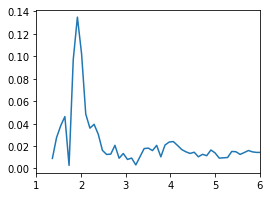

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:52.345921. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [17]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1,6))
ax.plot(m, denses)

### Finding Peaks

It may also be useful to find where these solvation shells are exactly. By finding the peaks and troughs of a radial density distribution function, we can see in what bands most of the oxygen atoms lie. The troughs, where relatively few oxygen atoms are, can therefore be used as one boundary of a solvation shell.

In [18]:
# get peak information
m, dense, peaks, mins = pdbionsurvey.analysis.get_peaks(b, 'Li', mindist=.2)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:52.486234. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


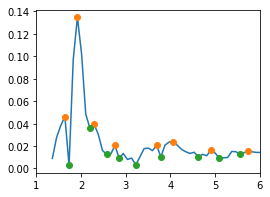

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:52.692380. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.set_xlim((1, 6))
ax.plot(m, dense)
ax.plot(m[peaks], dense[peaks], 'o')
ax.plot(m[mins], dense[mins], 'o')

### Closest Oxygen Distances

It is useful in some applications to know the average distance of the n$^\text{th}$ closest oxygen atom to the ion, particularly for those n's that correspond to the oxygen atoms in the first solvation shell.

Here we'll look at the closest six oxygen atoms to all of the Li+ ions in our sample.

In [20]:
# get closest oxygen information
oxys = pdbionsurvey.analysis.closest_oxy_distance(b, ['Li'], [2.5])

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:52.820218. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
oxys[0]

,1,2,3,4,5,6
1E5K_1423,1.488406,1.535717,1.591097,1.605139,3.177275,3.368793
1H4C_1423,1.468372,1.508946,1.598034,1.604956,3.098016,3.377499
1H4D_1436,1.451142,1.511678,1.585257,1.603862,3.131525,3.402755
1H4E_1437,1.452117,1.500569,1.607472,1.618758,3.065227,3.393507
1HJJ_1431,1.461252,1.483442,1.570276,1.596282,3.086967,3.372812
1HJL_1431,1.477931,1.508717,1.595408,1.626731,3.239752,3.460382
1KNW_3280,2.741698,2.748890,2.762185,2.910442,2.928319,4.169629
1KNW_3281,2.655058,2.714980,2.962401,3.063200,3.682053,4.168527
1MGW_782,1.804635,1.805865,1.829894,2.035545,3.494840,3.773953
1NQJ_3718,2.028468,2.102280,2.288262,2.343050,2.929987,3.553173


/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:54.119655. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
len(oxys[0])

89

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:54.170514. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


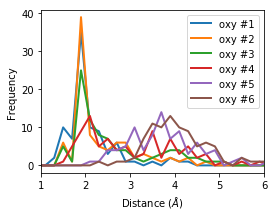

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-02-24 13:19:54.175518. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
ax = pdbionsurvey.analysis.graph_closest_oxy_distances(oxys[0], axlim=(1, 6))

# Conclusion

of what was done, noteworthy elements, emphasis is not on the science but on the computation, using the library, how the library is structured, assumptions/dependencies, discovering missing elements that should be in library, and testing the library